In [1]:
import pyspark
import os.path

from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from getpass import getpass
import pandas as pd
import pickle

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
conf = pyspark.SparkConf().setAll([('spark.app.name', 'Spark Data Exploration'),('spark.driver.memory','1g'),
                                  ('spark.executor.memory', '2048g')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

print (spark.version)
print (pyspark.version)

conf.getAll()

2.3.2
<module 'pyspark.version' from '/usr/local/lib/python3.6/dist-packages/pyspark/version.py'>


dict_items([('spark.app.name', 'Spark Data Exploration'), ('spark.driver.memory', '1g'), ('spark.executor.memory', '2048g')])

In [3]:
fpathA = 'ecommerce/order_items_dataset.csv'
fpathB = 'ecommerce/customers_dataset.csv'
fpathC = 'ecommerce/geolocation_dataset.csv'
fpathD = 'ecommerce/order_payments_dataset.csv'
fpathE = 'ecommerce/orders_dataset.csv'
fpathF = 'ecommerce/products_dataset.csv'
fpathG = 'ecommerce/sellers_dataset.csv'
fpathH = 'ecommerce/product_category_name_translation.csv'
fpathI = 'ecommerce/customer_reviews_dataset.csv'

orders = spark.read.csv(fpathE, inferSchema="true", header="true")
orderItems = spark.read.csv(fpathA, inferSchema="true", header="true")
customerReviews = spark.read.csv(fpathI, inferSchema="true", header="true")
products = spark.read.csv(fpathF, inferSchema="true", header="true")
# customers = spark.read.csv(fpathB, inferSchema="true", header="true")
# orderPayments = spark.read.csv(fpathD, inferSchema="true", header="true")

In [4]:
print('orderItems rows: ', orderItems.count())
print('order rows: ', orders.count())
print('customerReviews rows: ', customerReviews.count())
print('products rows: ', products.count())
# print('orderPayments rows: ', orderPayments.count())
# print('customers rows: ', customers.count())

orderItems rows:  112650
order rows:  99441
customerReviews rows:  105189
products rows:  32951


# Data preprocessing

In [5]:
# print('Order')
# orders.show(3)
# print('Order items')
# orderItems.show(3)
# print('Customer reviews')
# customerReviews.show(3)
# print('products')
# products.show(3)

In [6]:
# calculate the difference between deliver time and estimate time 
timeFmt = "yyyy-MM-dd HH:mm:ss"
timeDiff = (f.unix_timestamp('order_estimated_delivery_date', format=timeFmt)
            - f.unix_timestamp('order_customer_delivery_date', format=timeFmt))
diff = orders['order_id', 'order_customer_delivery_date', 'order_estimated_delivery_date'].dropna(how='any')
diff = diff.withColumn("Duration", timeDiff)
diff.show(3)
mergedOrders = orders.join(diff, on=['order_id'], how='inner')
# mergedOrders.show(3)

+--------------------+----------------------------+-----------------------------+--------+
|            order_id|order_customer_delivery_date|order_estimated_delivery_date|Duration|
+--------------------+----------------------------+-----------------------------+--------+
|e481f51cbdc54678b...|         2017-10-10 21:25:13|          2017-10-18 00:00:00|  614087|
|53cdb2fc8bc7dce0b...|         2018-08-07 15:27:45|          2018-08-13 00:00:00|  462735|
|47770eb9100c2d0c4...|         2018-08-17 18:06:29|          2018-09-04 00:00:00| 1490011|
+--------------------+----------------------------+-----------------------------+--------+
only showing top 3 rows



In [7]:
colNames_order = ['order_id', 'order_status', 'Duration']
colNames_items = ['order_id', 'product_id', 'price', 'freight_value'] # , 'order_item_id'
colNames_reviews = ['order_id', 'survey_score'] # 'review_id'
colNames_product = ['product_id', 'product_category_name']
mergedOrdersDF = mergedOrders[colNames_order]
orderItemsDF = orderItems[colNames_items]
customerReviewsDF = customerReviews[colNames_reviews]
productDF = products[colNames_product]
print('# of rows in mergedOrdersDF: ', mergedOrdersDF.count())
print('# of rows in orderItemsDF: ', orderItemsDF.count())
print('# of rows in customerReviewsDF: ', customerReviewsDF.count())
print('# of rows in productDF: ', productDF.count())

# of rows in mergedOrdersDF:  96476
# of rows in orderItemsDF:  112650
# of rows in customerReviewsDF:  105189
# of rows in productDF:  32951


In [8]:
# merge product and items with product_id
tempDF = orderItemsDF.join(productDF, on=['product_id'], how='inner')
# merge dataframe by aligning order_id
tempDF2 =  mergedOrdersDF.join(tempDF, on=['order_id'], how='inner')
mergedDF = customerReviewsDF.join(tempDF2, on=['order_id'], how='inner')
# mergedDF.show(5)
print('# of rows in mergedDF: ', mergedDF.count())

# of rows in mergedDF:  110847


### Clean mergedDF

In [9]:
# remove null
cleanDF = mergedDF.dropna(how='any')
print('# of rows remaining: ', cleanDF.count())

# of rows remaining:  109302


### Data analytics

In [10]:
from pyspark.sql.types import DoubleType, IntegerType
cleanDF = cleanDF.withColumn("survey_score", cleanDF["survey_score"].cast(DoubleType()))
print('Unbalanced data')
# cleanDF.select('survey_score').toPandas().hist()

Unbalanced data


# Supervised learning

In [11]:
# using order_id, product_id, review_id, price, freight_value to predict the survey_score
featureCols = ['freight_value', 'Duration', 'price'] # 'order_id', 'order_item_id', 'product_id', , 'product_category_name'
labelCol = 'survey_score'
feature_data = cleanDF[featureCols + [labelCol]].dropna(how='any')
print('Number of features: ', len(featureCols))
print('Number of rows in cleaned DataFrame: ', feature_data.count())
# changedTypedf = feature_data.withColumn("survey_score", feature_data["survey_score"].cast(DoubleType()))
# changedTypedf.printSchema()
# feature_data = changedTypedf

Number of features:  3
Number of rows in cleaned DataFrame:  109302


In [12]:
# onehot encoding for id
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
cols = featureCols
# cols = ['product_id', 'freight_value', 'Duration', 'price', 'product_category_name'] # 'order_id', 'order_item_id', 'freight_value'

indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
    for c in cols
]

encoders = [
    OneHotEncoder(
        inputCol=indexer.getOutputCol(),
        outputCol="{0}_encoded".format(indexer.getOutputCol())) 
    for indexer in indexers
]

assembler = VectorAssembler(
    inputCols=[encoder.getOutputCol() for encoder in encoders],
    outputCol="features"
)


pipeline = Pipeline(stages=indexers + encoders + [assembler])
vector_data = pipeline.fit(feature_data).transform(feature_data)['features', labelCol]# .show(3)
vector_data.printSchema()

root
 |-- features: vector (nullable = true)
 |-- survey_score: double (nullable = true)



In [13]:
vector_data.distinct().show(5)

+--------------------+------------+
|            features|survey_score|
+--------------------+------------+
|(103383,[556,6797...|         5.0|
|(103383,[869,8069...|         5.0|
|(103383,[2588,307...|         5.0|
|(103383,[129,2195...|         4.0|
|(103383,[37,24457...|         5.0|
+--------------------+------------+
only showing top 5 rows



### Split Data

In [14]:
trainDF, testDf = vector_data.randomSplit([0.85, 0.15], seed=12345)
print('trainDF')
trainDF.show(5)
print('testDf')
testDf.show(5)

trainDF
+--------------------+------------+
|            features|survey_score|
+--------------------+------------+
|(103383,[0,14817,...|         5.0|
|(103383,[0,14817,...|         5.0|
|(103383,[0,15427,...|         5.0|
|(103383,[0,22415,...|         5.0|
|(103383,[0,39858,...|         5.0|
+--------------------+------------+
only showing top 5 rows

testDf
+--------------------+------------+
|            features|survey_score|
+--------------------+------------+
|(103383,[0,23915,...|         5.0|
|(103383,[0,64252,...|         2.0|
|(103383,[1,57156,...|         4.0|
|(103383,[3,18671,...|         5.0|
|(103383,[4,59597,...|         5.0|
+--------------------+------------+
only showing top 5 rows



### Down Sampling

In [15]:
trainDF.groupBy("survey_score").count().show()

+------------+-----+
|survey_score|count|
+------------+-----+
|         1.0|10808|
|         4.0|17754|
|         3.0| 7788|
|         2.0| 3176|
|         5.0|53153|
+------------+-----+



In [16]:
# try
from sklearn.utils import resample
from numpy.random import randint
from pyspark.sql.functions import isnan, when, count, col, rand, isnull, avg, stddev, udf, lit
# Separate majority and minority classes
# df_majority = trainDF[trainDF.survey_score==5]
# df_minority1 = trainDF[trainDF.survey_score==1]
# df_minority2 = trainDF[trainDF.survey_score==2]
# df_minority3 = trainDF[trainDF.survey_score==3]
# df_minority4 = trainDF[trainDF.survey_score==4]

In [17]:
# trainDF, testDf = vector_data.randomSplit([0.75, 0.25], seed=12345)
def dowm_resample(base_features,ratio,class_field,base_class):
    pos = base_features.filter(col(class_field)==base_class)
    neg1 = base_features.filter(col(class_field)==1.0)
    neg2 = base_features.filter(col(class_field)==5.0)
    neg3 = base_features.filter(col(class_field)==3.0)
    neg4 = base_features.filter(col(class_field)==4.0)
    total_pos = pos.count()
    total_neg1 = neg1.count()
    total_neg2 = neg2.count()
    total_neg3 = neg3.count()
    total_neg4 = neg4.count()
    fraction1=float(total_pos*ratio)/float(total_neg1)
    fraction2=float(total_pos*ratio)/float(total_neg2)
    fraction3=float(total_pos*ratio)/float(total_neg3)
    fraction4=float(total_pos*ratio)/float(total_neg4)
    print(fraction1, fraction2, fraction3, fraction4)
    sampled1 = neg1.sample(False,fraction1)
    sampled2 = neg2.sample(False,fraction2)
    sampled3 = neg3.sample(False,fraction3)
    sampled4 = neg4.sample(False,fraction4)
    sampled1 = sampled1.union(pos)
    sampled2 = sampled2.union(sampled1)
    sampled3 = sampled3.union(sampled2)
    return sampled4.union(sampled3)

ratio = 1
resampleDF = dowm_resample(trainDF, ratio, 'survey_score', 2.0)

0.2938564026646928 0.0597520365736647 0.40780688238315355 0.17888926439112313


In [18]:
# trainDF.select('survey_score').toPandas().hist()
resampleDF.select('survey_score').toPandas().hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6793f30128>]],
      dtype=object)

In [19]:
# tempDF1.select('survey_score').toPandas().hist()

In [20]:
# tempDF1.printSchema()

In [21]:
# tempDF1.groupBy("survey_score").count().show()

In [22]:
# print('Before sampling data numbers: ', trainDF.select('survey_score').count())
# print('After sampling data numbers: ', tempDF.select('survey_score').count())
# tempDF.printSchema()

In [23]:
# print('original data')
# trainDF.groupBy("survey_score").count().show()
# print('resampling data')
# tempDF.groupBy("survey_score").count().show()

In [ ]:
# sratified sampling (keep ratio)
# fractions = trainDF.select("survey_score").distinct().withColumn("fraction", lit(0.5)).rdd.collectAsMap()
# sampled_df = trainDF.stat.sampleBy("survey_score", fractions, seed=12345)
# sampled_df.groupBy("survey_score").count().show()

### Up Sampling

In [ ]:
# trainDF.groupBy("survey_score").count().show()

In [ ]:
# Separate majority and minority classes
# df_majority = trainDF[trainDF.survey_score==5]
# df_minority1 = trainDF[trainDF.survey_score==1]
# df_minority2 = trainDF[trainDF.survey_score==2]
# df_minority3 = trainDF[trainDF.survey_score==3]
# df_minority4 = trainDF[trainDF.survey_score==4]

In [ ]:
# df_majority.show(5)

In [ ]:
def getrows(df, rownums=None):
    return df.rdd.zipWithIndex().filter(lambda x: x[1] in rownums).map(lambda x: x[0])

# getrows(df_majority, 1)

In [ ]:
def up_sample(base_features, ratio, class_field, base_class, target_count):
    # base_feature = trainDF
    # class_field = survey_score
    # base_class = df_minority
    minor_count = base_class.count()
    nums_up_sample = target_count - minor_count
    for i in range(nums_up_sample):
        randGen = randint(0, minor_count)
        temp_row = base_class
        base_class.union(base_class.row)
    pass

## Classification (not useful and time consuming)

from pyspark.ml.classification import DecisionTreeClassifier

treeModel = DecisionTreeClassifier(labelCol=labelCol, featuresCol='features', maxDepth=25)
#### Fit the model
modelNoTuning = treeModel.fit(trainDF)
print(modelNoTuning)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predDf = modelNoTuning.transform(testDf)

evaluator = MulticlassClassificationEvaluator(
    labelCol=labelCol, predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predDf)
print("Test Acc = %g " % (accuracy))

predDf = modelNoTuning.transform(trainDF)

evaluator = MulticlassClassificationEvaluator(
    labelCol=labelCol, predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predDf)
print("Train Acc = %g " % (accuracy))

from sklearn.metrics import confusion_matrix

classes = predDf.select(labelCol).groupBy(labelCol)\
                        .count().sort('count', ascending=False).toPandas()
classLabels = classes[labelCol].values.tolist()

classLabels = ['score review: '+'%d' % (x+1) for x in range(len(classLabels))]

yTrue = predDf.select(labelCol).toPandas()
yPred = predDf.select('prediction').toPandas()
cnfMatrix = confusion_matrix(yTrue, yPred)

from sklearn.metrics import classification_report

print (classification_report(yTrue, yPred, target_names=classLabels))

## Regression (Predict score)

In [19]:
from pyspark.ml.regression import DecisionTreeRegressor, GBTRegressor, GeneralizedLinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

### GBTRegressor (Unbalanced Data)

In [ ]:
# dt = DecisionTreeRegressor(featuresCol ='features', labelCol = labelCol)
dt = GBTRegressor(featuresCol ='features', labelCol = labelCol)
dt_model = dt.fit(trainDF)

In [ ]:
dt_predictions = dt_model.transform(testDf)
dt_evaluator = RegressionEvaluator(labelCol=labelCol, predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 1.3571


In [ ]:
# dt_predictions.select("prediction",labelCol,"features").show()#.describe().toPandas().round(2).transpose()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3f822e2c88>]],
      dtype=object)

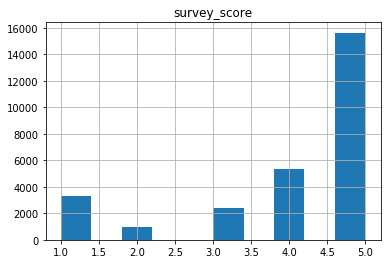

In [ ]:
dt_predictions.select('survey_score').toPandas().hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3f84c0bd68>]],
      dtype=object)

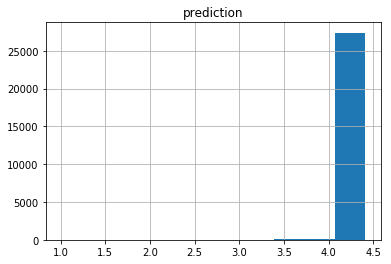

In [ ]:
dt_predictions.select('prediction').toPandas().hist()

In [ ]:
dt_predictions.select("prediction",labelCol,"features").show()

+------------------+------------+--------------------+
|        prediction|survey_score|            features|
+------------------+------------+--------------------+
| 4.080125385960791|         5.0|(103383,[0,23915,...|
| 4.080125385960791|         4.0|(103383,[0,52553,...|
| 4.080125385960791|         2.0|(103383,[0,64252,...|
| 4.080125385960791|         5.0|(103383,[1,42007,...|
| 4.080125385960791|         4.0|(103383,[1,57156,...|
| 4.080125385960791|         5.0|(103383,[1,68222,...|
| 4.080125385960791|         1.0|(103383,[2,96250,...|
| 4.080125385960791|         5.0|(103383,[3,18671,...|
| 4.080125385960791|         5.0|(103383,[3,44023,...|
| 4.080125385960791|         5.0|(103383,[4,59597,...|
| 4.080125385960791|         5.0|(103383,[4,78887,...|
|4.1215108021173155|         5.0|(103383,[5,19088,...|
| 4.080125385960791|         5.0|(103383,[6,13001,...|
| 4.080125385960791|         5.0|(103383,[6,81462,...|
| 4.080125385960791|         5.0|(103383,[6,96239,...|
| 4.080125

### GBTRegressor (Balanced Data)

In [ ]:
# dt = DecisionTreeRegressor(featuresCol ='features', labelCol = labelCol)
dt = GBTRegressor(featuresCol ='features', labelCol = labelCol)
dt_model = dt.fit(resampleDF)

In [ ]:
dt_predictions = dt_model.transform(testDf)
dt_evaluator = RegressionEvaluator(labelCol=labelCol, predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions) 
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

In [ ]:
dt_predictions.select('prediction').toPandas().hist()

In [ ]:
dt_predictions.select("prediction",labelCol,"features").show()

### DecisionTreeRegressor (Unbalanced Data)

In [ ]:
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = labelCol)
dt_model = dt.fit(trainDF)

In [ ]:
dt_predictions = dt_model.transform(testDf)
dt_evaluator = RegressionEvaluator(labelCol=labelCol, predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

In [ ]:
dt_predictions.select('prediction').toPandas().hist()

In [ ]:
dt_predictions.select("prediction",labelCol,"features").show()

### DecisionTreeRegressor (Balanced Data)

In [20]:
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = labelCol)
dt_model = dt.fit(resampleDF)

In [21]:
dt_predictions = dt_model.transform(testDf)
dt_evaluator = RegressionEvaluator(labelCol=labelCol, predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 1.71289


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6791371e48>]],
      dtype=object)

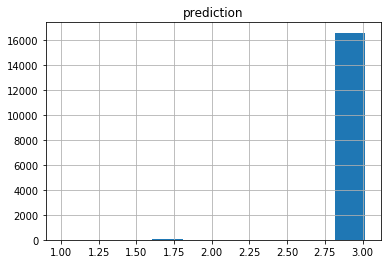

In [22]:
dt_predictions.select('prediction').toPandas().hist()

In [23]:
dt_predictions.select("prediction",labelCol,"features").show()

+------------------+------------+--------------------+
|        prediction|survey_score|            features|
+------------------+------------+--------------------+
|3.0176109300576583|         5.0|(103383,[0,23915,...|
|3.0176109300576583|         2.0|(103383,[0,64252,...|
|3.0176109300576583|         4.0|(103383,[1,57156,...|
|3.0176109300576583|         5.0|(103383,[3,18671,...|
|3.0176109300576583|         5.0|(103383,[4,59597,...|
|3.0176109300576583|         5.0|(103383,[5,19088,...|
|3.0176109300576583|         5.0|(103383,[6,13001,...|
|3.0176109300576583|         5.0|(103383,[6,81462,...|
|3.0176109300576583|         5.0|(103383,[6,96239,...|
|3.0176109300576583|         4.0|(103383,[7,7772,9...|
|3.0176109300576583|         5.0|(103383,[7,30442,...|
|3.0176109300576583|         4.0|(103383,[10,66084...|
|3.0176109300576583|         2.0|(103383,[12,18156...|
|3.0176109300576583|         2.0|(103383,[12,18156...|
|3.0176109300576583|         4.0|(103383,[12,83069...|
|3.0176109